# Spectral resolution and subaperturing

In these notes, I'm looking at the effect that subaperturing has on the spectral resolving power for Lynx. Since most parts of the Lynx design are still in the air, there are a lot of assumptions in here, some of which might have a major influence on the result. This is a document in progress that must evolve with the evolving mission design.

Please constact me (Moritz) if you want to use any of the figures or plots below for presentations or further reseach and I will prepare the high-resolution figures for you or provide you with the datasets behind the plot in numeric form. Please do not copy and paste the figures here; they are intentionally made at a lower resolution to optimize the display on a webpage.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [18]:
from __future__ import print_function, division
import sys
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
import astropy.units as u
import marxs
from marxs import visualization

from marxs.source import PointSource, FixedPointing, JitterPointing
from marxs.analysis import resolvingpower_from_photonlist

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from marxslynx import lynx

INFO: data files in version 0.0.dev9 (git hash 90d63baf333e3d111e194d4bad8eed3295e4bf66) [marxslynx.load_csv]
INFO: Loading data from /nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/marxslynx-0.0.dev9-py2.7.egg/marxslynx/data/gratings/efficiency.csv [marxslynx.load_csv]


In [88]:
import marxs.version
print('MARXS version {} (commit hash: {} from {})'.format(marxs.version.version, marxs.version.githash, marxs.version.timestamp))

MARXS version 1.1.dev579 (commit hash: e4533d88dd4019510ea51eed6d98f882c27b3f5c from 2017-06-26 10:43:11.132945)


In [4]:
import marxs.version
import marxslynx.version
print('MARXS version {} (commit hash: {} from {})'.format(marxs.version.version, marxs.version.githash, marxs.version.timestamp))
print('Lynx version {} (commit hash: {} from {})'.format(marxslynx.version.version, marxslynx.version.githash, marxslynx.version.timestamp))

MARXS version 1.1.dev579 (commit hash: e4533d88dd4019510ea51eed6d98f882c27b3f5c from 2017-06-26 10:43:11.132945)
Lynx version 0.0.dev9 (commit hash: 90d63baf333e3d111e194d4bad8eed3295e4bf66 from 2017-07-24 10:07:22.358544)


In [5]:
n_photons = 1e5

def run_lynx_simulation(energy):
    mysource = PointSource(coords=SkyCoord(0., 0., unit='deg'),
                           energy=energy,
                           flux=1.)
    fixedpointing = FixedPointing(coords=SkyCoord(0., 0., unit='deg'))
    photons = mysource.generate_photons(n_photons)
    photons = fixedpointing(photons)
    photons = lynx.default(photons)
    return photons[np.isfinite(photons['order'])]
    

In [6]:
facetpos = np.stack(lynx.gas.elem_pos)
#facetpos = np.stack([e.pos4d for e in lynx.gas.elements])
facetang = np.arctan2(facetpos[:, 2, 3], facetpos[:, 1, 3])
facetrad = np.sqrt(facetpos[:, 1, 3]**2 + facetpos[:, 2, 3]**2)
facetid = [e.id_num for e in lynx.gas.elements]
facettab = Table([facetid, facetrad, facetang], names=['facet', 'facet_rad', 'facet_ang'])

## Zeroth order image

First, we look at a zeroth order image. That allows us to check that we got the mirror right. This simulation uses a simplified mirror model. It does not simulate individual mirror shells, but instead is treats the mirror as a continuum. Every photon hitting the mirror plane is redicted to the focal point assuming an "ideal" mirror. Then, additional scatter is added both in the plane of reflection and out of the plane of reflection. Typically, for an individual shell, the scatter is larger in the plane of reflection due to figure errors and the scattering by particulates.

In this case, we want to simulate a mirror where the PSF is domianted by the mis-pointing of individual mirror shells (which is the case where sub-aperturing is the least useful). Mis-pointing of the shells happens in both x and y direction, which, looking at a single photon, can be simulated by assuming a perfect mirror and scatter of the same magnitude in the plane of the scattering and out of the plane of the scattering. 
Note that for simulations of gratings it would be cheating to apply a blur in the focal plane to account for the PSF in the way that many simpler simulations programs do it, because we need to know the direction of the photon already when it hits the gratings, and not just in the focal plane.

In [7]:
photons = run_lynx_simulation(0.5)

/nfs/melkor/d1/guenther/soft/anaconda/lib/python2.7/site-packages/marxs-1.1.dev579-py2.7-linux-x86_64.egg/marxs/math/polarization.py:126: RuntimeWarning: invalid value encountered in divide
  s = s / np.linalg.norm(s, axis=1)[:, None]


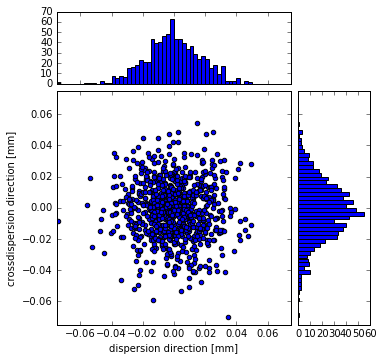

In [8]:
from matplotlib.ticker import NullFormatter

# the random data
ind = (photons['order'] == 0) & (np.abs(photons['proj_x'] < 10))
pgroups = photons[ind].group_by('order')
x = [p['proj_x'] for p in pgroups.groups]
y = [p['proj_y'] for p in pgroups.groups]

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(5, 5))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.scatter(x, y)

# now determine nice limits by hand:
binwidth = 0.0025
xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim((-lim, lim))
axScatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
histx = axHistx.hist(x, bins=bins, stacked=True)
histy = axHisty.hist(y, bins=bins, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axScatter.set_xlabel('dispersion direction [mm]')
axScatter.set_ylabel('crossdispersion direction [mm]')

In [9]:
def hpd(x, y):
    '''Simple estimate for the half-power-diameter
    '''
    r = np.sqrt((x - x.mean())**2 + (y - y.mean())**2)
    return np.median(r)

In [10]:
p0 = photons[photons['order'] == 0]
print('Estimate for HPD [in mm]:', hpd(p0['proj_x'], p0['proj_y']))
print('0.5 arcsec correspond to {} mm.'.format(np.deg2rad(0.5/3600.) * 9000.))

Estimate for HPD [in mm]: 0.0208021288614
0.5 arcsec correspond to 0.0218166156499 mm.


These numbers indicates that we set up our mirror correctly such that the HPD is close to 0.5 arcsec. Looking at the histrogram in the plot, the shape of the PSF is also roughly Gaussian, so that thsese simulations can be compared with other efforts for the Lynx development, where similar PSFs are used.

## A simulation at 0.5 keV (= 2.4 nm = 24 Angstrom)

First, we look at a simulation at one specific energy and see how the diffracted orders look on the detector and what we can learn from sub-aperturing. Later, we will repeat this analysis for a grid of photon energies, but it is useful to look in a little more detail for a single energy first to understand what is going on.

The convention that MARXS, our ray-trace code, uses for CAT gratings is to label the diffraction orders with negative numbers, so this is what we use in the following figures.

In [11]:
pgroups = photons.group_by('order')

In [83]:
print ('order  number of photons')
for key, group in zip(pgroups.groups.keys, pgroups.groups):
    print('{:3g}  {:8g}'.format(key.as_void()[0], len(group)))

order  number of photons
-12         3
-11         2
-10        15
 -9       109
 -8       586
 -7      1285
 -6     14851
 -5     19584
 -4      1634
 -3       437
 -2       899
 -1      2403
  0       805


In [13]:
photons = join(photons, facettab)

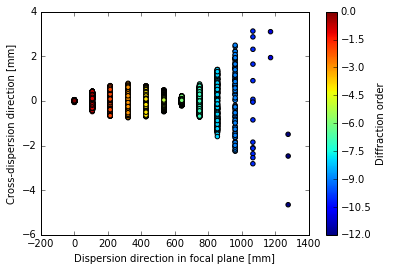

In [17]:
plt.scatter(photons['proj_x'], photons['proj_y'], c=photons['order'])
plt.colorbar(label='Diffraction order')
plt.xlabel('Dispersion direction in focal plane [mm]')
plt.ylabel('Cross-dispersion direction [mm]')

Figure above: Position of photons projected into the focal plane. Dispersion goes from left to right. Note that the scale of the x and y axis is *very* different!

We simuluate a Rowland spectrometer. As such, the CCD detectors are **not** in the focal plane, instead they follow the curved surface of the Rowland torus. This optimized for the spectral focus, i.e. it makes the orders narrow in dispersion direction, but at the cost of a wider distribution in the cross-dispersion direction. Only for the zeroth order (red, leftmost dot) do the imaging focus and the spectral focus agree and thus this order is circular as shown in the plot above. For CAT gratings, it is useful to use a *tilted* Rowland torus, which intersects the focal plane a second time, thus there is a second place (around 700 mm for the parameters chosen here) where the dispersed order is small in dispersion and cross-dispersion direction. This leads the fish-shaped distribution seen in the plot above. We now look at one of those orders in more detail.

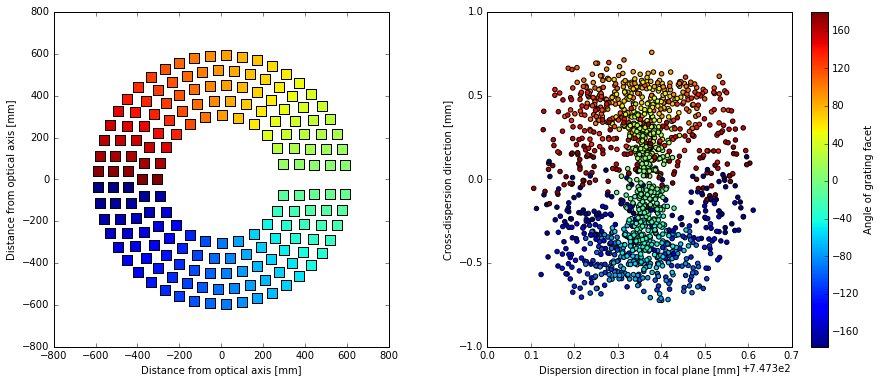

In [84]:
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121, aspect='equal')
ax1.scatter(facetpos[:, 1, 3], facetpos[:, 2, 3], c=np.rad2deg(facettab['facet_ang']),
            s=100, marker='s')
ax2 = fig.add_subplot(122)
ind = (photons['order'] == -7) & (photons['proj_x'] > 0)
scat = ax2.scatter(photons['proj_x'][ind], photons['proj_y'][ind], 
            c=np.rad2deg(photons['facet_ang'])[ind])
#plt.xlim([-0.1, 0.1])
#plt.ylim([-0.1, 0.1])
plt.colorbar(scat, ax=ax2, label='Angle of grating facet')
ax2.set_xlabel('Dispersion direction in focal plane [mm]')
ax2.set_ylabel('Cross-dispersion direction [mm]')
ax1.set_xlabel('Distance from optical axis [mm]')
ax1.set_ylabel('Distance from optical axis [mm]')

In [46]:
np.rad2deg(np.arctan(0.75/9.))

4.7636416907261774

The left plot shows the arrangement of the grating facets looking from end of the mirrors towards the focal plane. The dispersion direction is from left to right and cross-dispersion from top to bottom. There is no special meaning in that gap at the middle right. It's just where I started distributing the grating facets. The gap is just too small to place another set of facets so it's left empty. The distribution of facets can be improved to reduce the uncovered area in between, but that this stage it is not useful to spend to much detailed work on that. Note that the coloring schme is different than in the 3D view on the interactive 3d website. Facets are colored according to the angle that the facet center has towards the positive dispersion direction.

The plot on the right shows a spefic grating order on the detector (order 7). The detector is cylindrical following the Rowland circle. Intersection positions with this detecor are the projected on the focal plane so that I can properly display them in a two-dimensional plot. Individual photons are colored according to the grating facet that they passed through. There are several things we can learn from this plot: First, note that the x and y axis are not to scale, this really is much longer in cross-dispersion direction (top to bottom) and narrow in the dispersion direction (left to right). Second, the aboslute position along the dispersion direction is 75 cm from the focal point, so the dispersion angle is about 5 deg - significantly more than in Chandra or XMM-Newton. Thus, abberations that do not need to be considered for Chandra or XMM-Newton can be important here. 

So, we can now look at the distribution of colors and we see immediately that the distribution is not homogeneous. Photons that went through the cyan, green, and yellow colored gratings are distributed a narrower than the blue and red points. Thus, sub-aperturing *can* defintely increase the spectral resolving power. However, the pattern of the sub-aperturing is completely different than the "normal" pattern. Typically, sub-aperturing is done using only an area along the cross-dispersion direction (here the orange and light blue gratings). In contrast, here, we achieve the best spectral resolving power by using only gratings that are located along the forward dispersion direction.

This might be a surprising result at first glance, but thinking back to the assumptions that went into this simulation, it might seem a little more sensible. We set up the PSF such that there is no difference between in-plane and out-of-plane scatter and thus there is nothing special about the cross-dispersion direction. Instead the shape of the PSF is dominated by other things. Now, recall that this order is located about 75 cm from the optical axis; at the same time the facets go from -60 cm (red and blue) to +60 cm (light green). There is a consideralbe path length difference between those photons. The light green facets are located essentially "directly above" the order, while the red/blue ones are 1.5 m to the side; so it should not come a a complete surprise that the abberations differ between those two groups.

In the following, I show how much better the spectral resolving power can be for different opening angles of the subaperture. That angle measures the angle between the center of a facet and the positive horizonal axis (the gap in the left iamge above). *There is no second mirrored sector*. For example, a subaperture angle of 30 degrees includes the cyan and light green gratings, 90 deg included lightblue, cyan, green, yellow, and orange, and only the full aperture (suaperture angle 180 deg) includes all gratings, even the dark red and dark blue ones.

In [52]:
subaperangle = np.linspace(0, np.pi, 7)[1:]
resolvingpower = np.zeros((len(subaperangle), len(lynx.order_selector.orders)))
for i, ang in enumerate(subaperangle):
    res, width, pos = resolvingpower_from_photonlist(photons[np.abs(photons['facet_ang']) < ang],
                                                     lynx.order_selector.orders)
    resolvingpower[i, :] = res

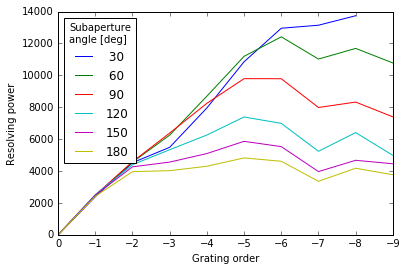

In [58]:
for i, ang in enumerate(subaperangle):
    plt.plot(lynx.order_selector.orders, 
             resolvingpower[i, :], 
             label='{:3.0f}'.format(np.rad2deg(ang)))
plt.legend(title='Subaperture\nangle [deg]', loc='upper left')
plt.ylabel('Resolving power')
plt.xlabel('Grating order')
plt.gca().invert_xaxis()

Resolving power depending on the grating order (or diffraction angle). Sub-aperturing does little for low orders located close to the optical axis but can improve the resolving power up to a factor of three for higher orders. In practice though, only some orders receive a sufficient number of photons to do spectral analysis. Thus, we can take a weighted average of the resolving power for all orders where the resolving power for each order is weighted by the number of photons it receives.

In [21]:
resolvingpower = np.ma.masked_invalid(resolvingpower)
np.ma.average(resolvingpower, axis=1, 
              weights=lynx.order_selector.probabilities([0.5], [0], [np.deg2rad(lynx.blazeang)])[1].flatten())

masked_array(data = [10817.615849945838 10760.061594826599 9028.323124869601 6721.9043936942535
 5369.585649706748 4479.75456275497],
             mask = [False False False False False False],
       fill_value = 1e+20)

## Simulations for different energies

Now, I run simulations wit hthe same set-up as above for different input energies. The goal is not to produce a fine grid, but rather to set a few goalposts to see how the effect of sub-aperturing changes with energy.

In [22]:
subaperangle = np.linspace(0, np.pi, 7)[1:]
energy = [0.3, 0.6, 1.0, 1.4, 1.8] * u.keV

In [23]:
energy.to(u.nm, equivalencies=u.spectral())

<Quantity [ 4.13280643, 2.06640322, 1.23984193, 0.88560138, 0.68880107] nm>

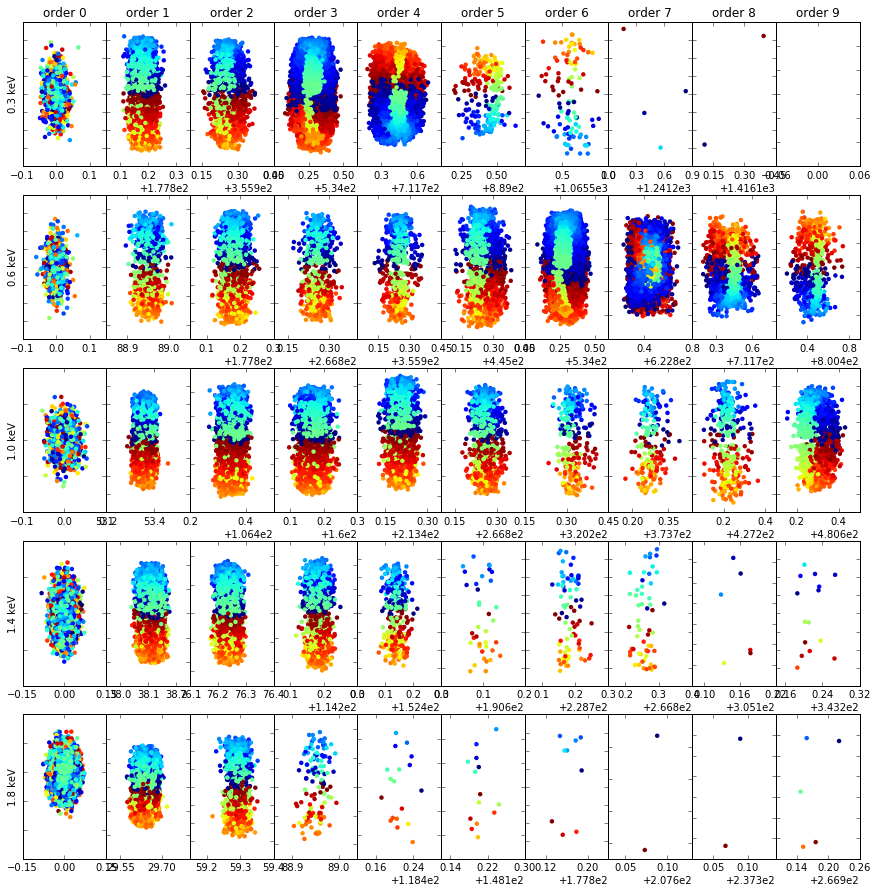

In [87]:
from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize=(15, 15))
lenen = len(energy)
lenord = 10  # cut-off orders that never have many photons

axes = np.empty((lenen, lenord), dtype=object)

for i in range(len(energy)):
    axes[i, 0] = fig.add_subplot(lenen, lenord, lenord * i + 1)
    axes[i, 0].set_ylabel(str(energy[i]))
    plt.setp(axes[i, 0].get_yticklabels(), visible=False)
    for j in range(1, lenord):
        axes[i, j] = fig.add_subplot(lenen, lenord, lenord * i + j + 1) #, sharey=axes[i, 0])
        plt.setp(axes[i, j].get_yticklabels(), visible=False)
        
for i in range(len(energy)):
    phot = phot_en[i]
    for j in range(0, lenord):      
        order = lynx.order_selector.orders[j]
        ind = (phot['order'] == order) & (np.abs(phot['proj_y']) < 10)
        axes[i, j].scatter(phot['proj_x'][ind], phot['proj_y'][ind], 
                            c=np.rad2deg(phot['facet_ang'])[ind],
                          edgecolors='none')
        

for j in range(0, lenord):
    axes[0, j].set_title('order {}'.format(j))
    
#axes[-1, 5].set_xlabel('position on dispersion direction [mm]. Note that the scale siffers for every plot.')
    
fig.subplots_adjust(wspace=0)

The plot above shows the PSF for different grating orders and energies. The energy for each row is listed on the left, and then the PSF is shown for order 0, -1, -2 ,... from left to right. THe x-axis in eahc panel has a differnet scaling and shows the position in dispersion direction (in mm) measured from the optical axis. Dots are colored according to the angle of the facet that the photon went through using the same color scale as above. For each order, the y axis is scaled differently. As shown in the fish-shaped plot above, the width in the y direction ranges from 0.02 mm for order 0 to a a few mm for higher orders. Using a the same scaling in y direction for all orders in a row would hide several of the details for the PSFs I'm going to discuss now, but keep in mind that the scaling of x and y axis is not the same. For exmaple, all zeroth orders are really circular and not elliptical.

Let me know highlight a few insteresting aspects about the use of subaperturing for different energies and orders. This discussion here is qualitatively and I try to explain why things look the way they do and later I will show the actual number for the resolving power. Looking at the zeroth order for any energy, all the colors are well mixed in the plot and sub-aperturing will not do anything to change that. This is simply the result of our setup, where the scattering of the mirror is the same in every direction. At 0.3 keV most of the photons are found in order -3 and -4. In both cases, we see that sub-aperturing as discussed in detail above (selecting the angles for cyan, green, and yellow) would significantly narrow the order and thus improve the spectral resolving power. It is interesting to note that the color scheme seems flipped between order -3 and -4. In order -3 the blue-ish photons are found on the top and the reddish photons at the bottom, in order -4 that is reversed. The Rowland torus optimizes the focussing in the dispersion direction, but the focus in the cross-dispersion direction is different. In one case the detector is located below the focus in cross-dispersion direction (so in y direction photons have passed through the focus and spread out again), in the other case it is above the cross-dispersion focus. This flip happens around 62 cm, where the 7 order of 0.6 keV photons is located. Photons of higher energy (and thus lower wavelength) are not dispersed this far out and thus there is no flip in the plots for 1.0, 1.4, and 1.8 keV.

In general, for higher energies where the grating orders are located closer to the optical axis, the distribution of the photons in each order depends less on the angle of the facet that they went through and thus sub-aperturing cannot do much to improve the spectral resolving power. The simulations for 1.4 and 1.8 keV photons show this. At these energies, the efficiency also peaks at much lower orders and the relevant signal is only a few cm from the optical axis (for example, order -2 for 1.8 keV is at 59 mm = 5.9 cm. 

At 1 keV, a significant number of photons are seen in very low orders (-1 to -3) where sub-aperturing is not relevant, but then again there are many photons in order -9. If Lynx uses sub-aperturing, then one could analyze the photons in order 9 for high-resolution work, if instead a larger number of photons is required for the science goal, but spectral resolving power is not crucial, then the observer could include the lower orders in the analysis. However, for simplicity, I will just average the resolving power for all orders when I show plots of resolving power vs sub-aperturing angle below.

I want to point out one more feature: While the signal of the cyan, green, and yellow photons is generally is approximately centered on the same position as the wider distribution for the red and blue photons, this is not the case around 40-50 cm from the optical axis (order -2 for 0.3 keV; order -5 for 0.6 keV; order -9 for 1 keV).


In [61]:
phot_en = []

for i, e in enumerate(energy):
    phot = run_lynx_simulation(e.value)
    phot = join(phot, facettab)
    phot_en.append(phot)


In [75]:
resolvingpower_en = np.zeros((len(subaperangle), len(energy)))

for i, e in enumerate(energy):
    phot = phot_en[i]
    resolvingpower = np.zeros((len(subaperangle), len(lynx.order_selector.orders)))
    for j, ang in enumerate(subaperangle):
        res, width, pos = resolvingpower_from_photonlist(phot[np.abs(phot['facet_ang']) < ang],
                                                         lynx.order_selector.orders)
        resolvingpower[j, :] = res
        
    resolvingpower = np.ma.masked_invalid(resolvingpower)
    # Mask out the zeros order which always as resolving power 0 
    resolvingpower[:, 0] = np.ma.masked
    res = np.ma.average(resolvingpower, axis=1, 
                        weights=lynx.order_selector.probabilities([e], [0], [np.deg2rad(lynx.blazeang)])[1].flatten())
    resolvingpower_en[:, i] = res
        

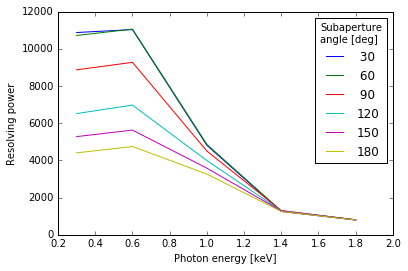

In [77]:
for i, ang in enumerate(subaperangle):
    plt.plot(energy, resolvingpower_en[i, :], label='{:3.0f}'.format(np.rad2deg(ang)))
plt.legend(title='Subaperture\nangle [deg]')
plt.ylabel('Resolving power')
plt.xlabel('Photon energy [keV]')

This plot shows the spectral resolving power vs energy for different sub-aperturing angles. When calculating the average, different orders are weighted according to the number of photons they receive. Sub-aperturing will not increase the resolving power for high energies, but sacrificing 2/3 of the effective area in a 60 degree sub-aperture angle would increase the resolving power at low energies by almost a factor of three.

## Future work

Much remains to be done to study this in more detail. There are several parameters in the simulation that I fixed to certain values based on experience with simulating other observatories, but that remain to be studied in the context of Lynx. An incomplete list is:

- **mirror PSF** Does this analysis hold if the mirror shells are aligned better so that scattering in the plane of reflection is actually different from the plane of reflection? This might lead to a more conventional pattern of the sub-aperturing.
- **Facet size** Flat grating facets of finite size always deviate from the Rowland torus. The facets here are square with 50 mm sides. How does the resolving power improve with smaller facets?
- **Torus tilt** The torus is tilted by a little more than twice the facet blaze angle. There are two free parameters in here which Heilmann et al. 2010 call "hinge points". I don't think that the exact numbers are critical for the answer, but that should be checked.